# Importing Libraries

In [2]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm

import matplotlib.pyplot as plt

# noinspection PyUnresolvedReferences
from tensorflow.keras.preprocessing.text import Tokenizer
# noinspection PyUnresolvedReferences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from helper import *

# Loading Data

In [41]:
data_path = "../data/processed_data_temp.csv"
pickle_path = "../data/data.pickle"

with open(pickle_path, "rb") as f:
    data = pickle.load(f)

df = pd.DataFrame(data, columns=['text', 'positive', 'mixed', 'negative', 'id']) 

# drop id column
df = df.drop(columns=["id"])

# 
# # df = pd.read_csv(data_path)
# df = data
# # drop id, source, date, time, views, forwards, containing_media
# df = df.drop(columns=["id", "source", "date", "time", "views", "forwards", "containing_media", "sum"])
# df = df.dropna()
df

,text,positive,mixed,negative
0,🏦 Колишні російські власники вже державного С...,0.179402,0.011628,0.808970
1,❤️‍🩹 Кожна хвилина на фронті - це життя війсь...,0.989399,0.000000,0.010601
2,Більш ніж половина українських громадян — 56% ...,0.928571,0.040816,0.030612
3,"""Це процес, який буде тривати і набирати оберт...",0.985535,0.011801,0.002665
4,Нардепу від ОПЗЖ Пономарьову СБУ повідомила пр...,0.889975,0.007222,0.102804
...,...,...,...,...
187250,Ти сильна. Ти талановита. Ти красива. Ти мрійл...,0.986304,0.000000,0.013696
187251,⚡️На Дніпропетровщині російські військові обс...,0.022256,0.000000,0.977744
187252,Генштаб ЗСУ: Основні зусилля ворог зосереджує...,0.309588,0.000000,0.690412
187253,Повітряна тривога в Бахмутський район та Покр...,0.027384,0.000000,0.972616


# Preprocessing Data

In [47]:
def filter_string_rows(df):
    data = []
    # Check if row[0] is a string
    for row in df.values:
        if isinstance(row[0], str):
            data.append(row)

    print(f"Data length: {len(data)}")
    return data

def clean_data(data):
    for i in range(len(data)):
        data[i][0] = clean_text(data[i][0])
        if i % 1000 == 0:
            print(f"Cleaning: {i + 1}/{len(data)}", end="\r")
    print(f"Cleaning: {len(data)}/{len(data)}")
    return data

def process_data(data):
    for i in range(len(data)):
        data[i][0] = replace_numbers(data[i][0])
        if i % 1000 == 0:
            print(f"Processing: {i + 1}/{len(data)}", end="\r")
    print(f"Processing: {len(data)}/{len(data)}")
    return data

def articles_answers_crop(data):
    articles = [row[0] for row in data]
    answers = [[float(value) for value in row[1:]] for row in data]
    return articles, answers

def argmax_convertion(answers):
    # convert [0.8, 0.1, 0.1] to [1, 0, 0]
    one_maxtix = np.eye(len(answers[0]))
    for i in range(len(answers)):
        answers[i] = one_maxtix[np.argmax(answers[i])]
        if i % 1000 == 0:
            print(f"Argmax: {i + 1}/{len(answers)}", end="\r")
    print(f"Argmax: {len(answers)}/{len(answers)}")
    return answers


data = filter_string_rows(df)
data = clean_data(data)
data = process_data(data)
articles, labels = articles_answers_crop(data)
answers = argmax_convertion(labels)
print(f"Articles: {len(articles)}, Answers: {len(labels)}")
print(f"Example: {articles[0]}, {labels[0]}")

Data length: 187255
Cleaning: 187255/187255
Processing: 187255/187255
Argmax: 187255/187255
Articles: 187255, Answers: 187255
Example:  колишні російські власники вже державного сенс банку хотіли довести його до банкрутства вони хотіли вивести з нього мільярдні активи і переоформити власну частку в управлінні на підставних людей щоб приховати сліди банк планували довести до штучного банкрутства тепер розслідуванням цієї справи займаються сбу та офіс генпрокурора подписаться uanovo , [0. 0. 1.]


# Tokenizing, truncating and padding data

In [214]:
tokenizer = spm.SentencePieceProcessor(model_file='./tokenizer/spm_50000.model')

print(f"Vocab size: {tokenizer.vocab_size()}")

Vocab size: 50000


In [215]:
articles_encoded = tokenizer.encode(articles)

In [216]:
def words_per_article(articles):
    # calculate words in each article
    words_in_articles = [len(article) for article in articles]

    # calculate min, max, mean
    min_words = min(words_in_articles)
    max_words = max(words_in_articles)
    mean_words = sum(words_in_articles) / len(articles)

    return min_words, max_words, mean_words

min_words, max_words, mean_words = words_per_article(articles_encoded)
print(f"Min Words: {min_words}, Max Words: {max_words}, Mean Words: {mean_words}")

Min Words: 0, Max Words: 1474, Mean Words: 47.39269979439801


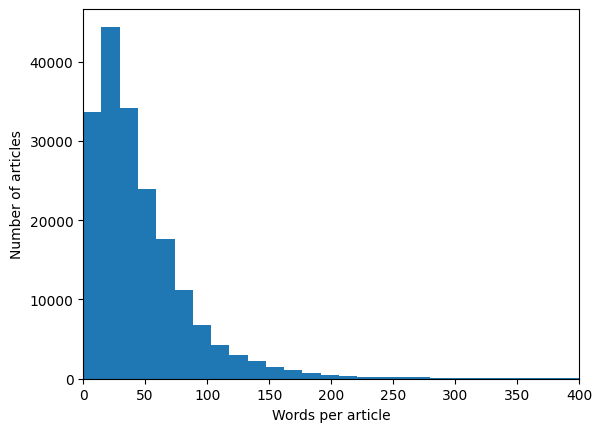

In [217]:
# plot distribution of words per article
words_per_article = [len(article) for article in articles_encoded]
plt.hist(words_per_article, bins=100)
plt.xlabel('Words per article')
plt.ylabel('Number of articles')
plt.xlim(0, 400)
plt.show()

In [218]:
(train_articles, train_labels), (test_articles, test_labels) = split_data(articles_encoded, labels, 0.8)
(test_articles, test_labels), (val_articles, val_labels) = split_data(test_articles, test_labels, 0.5)
print(f"Train articles: {len(train_articles)}, Train labels: {len(train_labels)}")
print(f"Test articles: {len(test_articles)}, Test labels: {len(test_labels)}")
print(f"Val articles: {len(val_articles)}, Val labels: {len(val_labels)}")

Train articles: 149804, Train labels: 149804
Test articles: 18725, Test labels: 18725
Val articles: 18726, Val labels: 18726


In [219]:
# pad sequences
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
vocab_size = tokenizer.vocab_size()

train_padded = pad_sequences(train_articles, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_articles, maxlen=max_length, padding=padding_type, truncating=trunc_type)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

print(f"Train padded: {len(train_padded)}, Test padded: {len(test_padded)}")
print(f"Train labels: {len(train_labels)}, Test labels: {len(test_labels)}")

Train padded: 149804, Test padded: 18725
Train labels: 149804, Test labels: 18725


In [220]:
import keras.layers as L

def create_model(vocab_size, embedding_dim, max_length):
    input = L.Input(shape=(max_length,))
    x = L.Embedding(vocab_size, embedding_dim)(input)
    x = L.Flatten()(x)
    x = L.Dense(8, activation="relu")(x)
    x = L.Dropout(0.2)(x)
    x = L.Dense(3, activation="softmax")(x)
    model = tf.keras.Model(inputs=input, outputs=x)
    return model

embedding_dim = 1

model = create_model(vocab_size, embedding_dim, max_length)

# loss = tf.keras.losses.KLDivergence()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
metrics = ["accuracy"]
model.compile(
    loss=loss, 
    optimizer=optimizer, 
    metrics=metrics)

model.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 100)]             0         
                                                                 
 embedding_23 (Embedding)    (None, 100, 1)            50000     
                                                                 
 flatten_20 (Flatten)        (None, 100)               0         
                                                                 
 dense_52 (Dense)            (None, 8)                 808       
                                                                 
 dropout_23 (Dropout)        (None, 8)                 0         
                                                                 
 dense_53 (Dense)            (None, 3)                 27        
                                                                 
Total params: 50835 (198.57 KB)
Trainable params: 50835 (1

In [221]:
num_epochs = 2
batch_size = 1024
model_name = "like_model-spm"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"../models/{model_name}_checkpoint.h5",
    save_weights_only=False,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True
)
history = model.fit(
    train_padded, train_labels, 
    epochs=num_epochs, 
    validation_data=(test_padded, test_labels), 
    callbacks=[checkpoint_callback],
    # batch_size=batch_size
)

Epoch 1/2
4682/4682 [==============================] - 6s 1ms/step - loss: 0.6506 - accuracy: 0.7460 - val_loss: 0.5208 - val_accuracy: 0.8122
Epoch 2/2
 116/4682 [..............................] - ETA: 5s - loss: 0.4988 - accuracy: 0.8330

C:\#Coding\Python\_uvPythonEnvironment\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4682/4682 [==============================] - 5s 1ms/step - loss: 0.4947 - accuracy: 0.8288 - val_loss: 0.5112 - val_accuracy: 0.8162


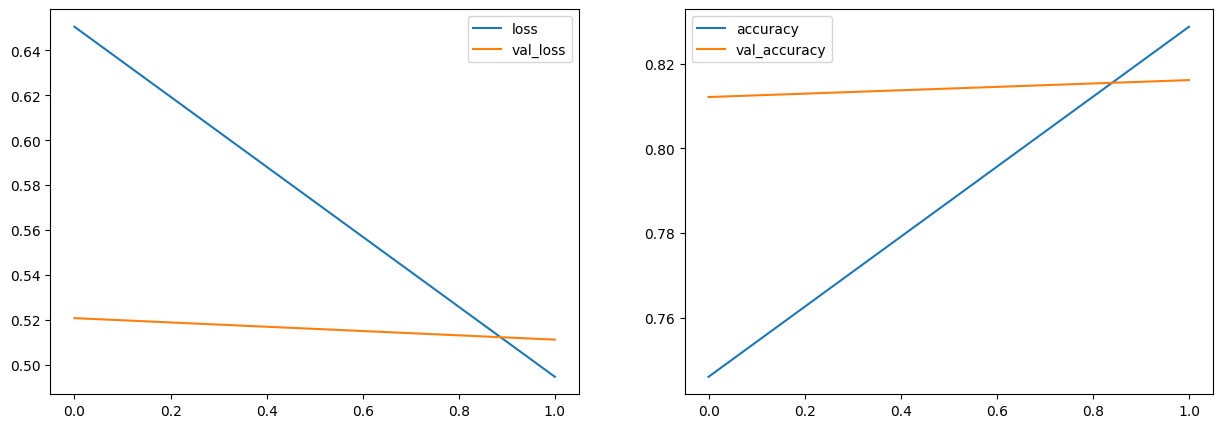

In [222]:
def plot_history(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()

    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()

def plot_history_as_subplots(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history["loss"], label="loss")
    ax1.plot(history.history["val_loss"], label="val_loss")
    ax1.legend()
    ax2.plot(history.history["accuracy"], label="accuracy")
    ax2.plot(history.history["val_accuracy"], label="val_accuracy")
    ax2.legend()
    plt.show()

plot_history_as_subplots(history)

In [223]:
# load best model
model = tf.keras.models.load_model(f"../models/{model_name}_checkpoint.h5")

# evaluate on test data
model.evaluate(test_padded, test_labels)

586/586 [==============================] - 1s 728us/step - loss: 0.5112 - accuracy: 0.8162


[0.5112418532371521, 0.8161816000938416]

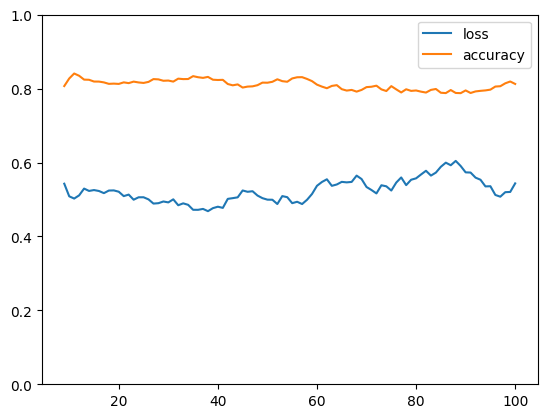

In [224]:
splited = {}
for i in range(len(test_labels)):
    varticle = test_articles[i]
    vanswer = test_labels[i]

    length = len(varticle)
    if length > max_length:
        continue
    if length not in splited:
        splited[length] = []

    splited[length].append((varticle, vanswer))

results = {}
# sort splited by length
splited = dict(sorted(splited.items(), key=lambda item: item[0]))
for key in splited:
    varticles = [row[0] for row in splited[key]]
    vanswers = [row[1] for row in splited[key]]
    varticles_padded = pad_sequences(varticles, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    vanswers = np.array(vanswers)
    # print(f"Length: {key}, Articles: {len(varticles)}, Answers: {len(vanswers)}")
    pred = model.evaluate(varticles_padded, vanswers, verbose=0)
    # get mean of loss and accuracy
    results[key] = (pred[0], pred[1])

# make df from results
results_df = pd.DataFrame(results.items(), columns=["Length", "Results"])
# use rolling mean to smooth the data
results_df["Loss"] = results_df["Results"].apply(lambda x: x[0]).rolling(10).mean()
results_df["Accuracy"] = results_df["Results"].apply(lambda x: x[1]).rolling(10).mean()
results_df = results_df.drop(columns=["Results"])

# plot results
plt.plot(results_df["Length"], results_df["Loss"], label="loss")
plt.plot(results_df["Length"], results_df["Accuracy"], label="accuracy")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [225]:
# save model
model.save(f"../models/{model_name}.h5")

C:\#Coding\Python\_uvPythonEnvironment\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 84ms/step
Article: Комітет з питань гуманітарної та інформаційної політики не підтримав відставку Ткаченка. Зазначають, що рішення прийматиме Верховна Рада.
Unfamiliar Words: 0


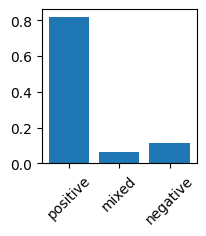

In [226]:
o_article = "Комітет з питань гуманітарної та інформаційної політики не підтримав відставку Ткаченка. Зазначають, що рішення прийматиме Верховна Рада."

article = o_article.lower()
article = tokenizer.encode(article)
article_padded = pad_sequences([article], maxlen=max_length, padding=padding_type, truncating=trunc_type)

predictions = model.predict(article_padded)

count = sum([1 for num in article_padded[0] if num == 1])
print(f"Article: {o_article}")
print(f"Unfamiliar Words: {count}")

plt.bar(df.columns[1:], predictions[0])
plt.gcf().set_size_inches(2, 2)
plt.xticks(rotation=45)
plt.show()

In [227]:
predictions = model.predict(article_padded)
print(f"Predictions: {predictions}")
print(f"columns: {df.columns[1:]}")

1/1 [==============================] - 0s 15ms/step
Predictions: [[0.8207334  0.06412252 0.11514406]]
columns: Index(['positive', 'mixed', 'negative'], dtype='object')


In [228]:

with open("../data/temp/data.pickle", "rb") as f:
    data = pickle.load(f)

# convert data to dataframe
test_df = pd.DataFrame(data, columns=['text', 'like', 'heart', 'smile', 'angry', 'sad', 'trigger', 'spread'])

# merge like and heart, angry and sad
for row in test_df.values:
    row[1] = float(row[1]) + float(row[2])
    row[4] = float(row[4]) + float(row[5])
test_df = test_df.drop(columns=["heart", "sad", "trigger", "spread"])
# rename like -> positive, angry -> negative, smile -> neutral
test_df = test_df.rename(columns={"like": "positive", "angry": "negative", "smile": "neutral"})
test_df = test_df.dropna()
test_df

,text,positive,neutral,negative
0,"""Зерновий коридор"" не буде у безпеці, якщо ООН...",0.973281,0.012180747,0.014538
1,"У міноборони рф заявили, що усі кораблі, які п...",0.029799,0.071379071,0.898822
2,Міжнародний кримінальний суд приділяє недостат...,0.92169,0.007887324,0.070423
3,Ситуація на фронті за добу\n\nПротивник і нада...,0.970326,0.003709199,0.025964
4,"Резніков сказав, коли в Україні будуть літаки ...",0.692113,0.019716886,0.28817
...,...,...,...,...
5300,Журналіста російського пропагандистського ЗМІ ...,0.847131,0.141480508,0.011389
5301,Європарламент ухвалив Акт на підтримку виробни...,0.986479,0.009734992,0.003786
5302,Речник путіна дмитро пєсков назвав «порушенням...,0.145451,0.841038632,0.013511
5303,!?Внаслідок атаки БПЛА на Суми загинуло троє л...,0.026095,0.00329934,0.970606


In [229]:
# create validation data from test_df
test_articles = [row[0] for row in test_df.values]
test_answers = [[float(value) for value in row[1:]] for row in test_df.values]
print(f"Test: {len(test_articles)}")

Test: 5305


In [230]:
for i in range(len(test_articles)):
    test_articles[i] = test_articles[i].lower()
    test_articles[i] = tokenizer.encode(test_articles[i])
    print(f"{i + 1}/{len(test_articles)}", end="\r")

test_padded = pad_sequences(test_articles, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(f"Test Padded: {test_padded.shape}")

Test Padded: (5305, 100)


In [231]:
test_answers = np.array(test_answers)

# evaluate on test data
model.evaluate(test_padded, test_answers)

166/166 [==============================] - 0s 741us/step - loss: 0.5055 - accuracy: 0.8560


[0.5055369734764099, 0.8559849262237549]

In [232]:
e = model.layers[1]
weights = e.get_weights()[0]
print(weights.shape)

(50000, 1)


In [233]:
vocabs = [tokenizer.id_to_piece(i) for i in range(vocab_size)]
vocabs = {vocabs[i]: i for i in range(vocab_size)}
reverse_word_index = dict([(value, key) for (key, value) in vocabs.items()])

In [234]:
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write("\t".join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()